In [1]:
import sys
rex_path = "/home/r2ci/rex"
if rex_path not in sys.path:
    sys.path.append(rex_path)
print(sys.path)

['/home/r2ci/rex/notebooks', '/home/r2ci/rex', '/home/r2ci/sbx', '/home/r2ci/Jumpy', '/home/r2ci/brax', '', '/home/r2ci/catkin_ws/devel/lib/python3/dist-packages', '/home/r2ci/interbotix_ws/devel/lib/python3/dist-packages', '/opt/ros/noetic/lib/python3/dist-packages', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '/home/r2ci/.cache/pypoetry/virtualenvs/rex-lib-fAzIlxw_-py3.8/lib/python3.8/site-packages']


In [2]:
import time
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import jumpy
import jumpy.numpy as jp
import jax
import jax.numpy as jnp
import jax.random as rnd
from jax.tree_util import tree_map

import rex.utils as utils
import rex.open_colors as oc
from rex.wrappers import GymWrapper, AutoResetWrapper, VecGymWrapper
from rex.proto import log_pb2
from rex.node import Node
from rex.agent import Agent
from rex.constants import LATEST, BUFFER, SILENT, DEBUG, INFO, WARN, SYNC, ASYNC, REAL_TIME, FAST_AS_POSSIBLE, FREQUENCY, PHASE, SIMULATED, WALL_CLOCK, VECTORIZED
from rex.distributions import Gaussian, GMM
from rex.base import GraphState, StepState
from scripts.dummy import DummyNode, DummyAgent

utils.set_log_level(WARN)

In [3]:
import experiments as exp
import stable_baselines3 as sb3
import envs.double_pendulum as dpend

# Environment
ENV = "double_pendulum"
DIST_FILE = f"21eps_pretrained_sbx_sac_gmms_2comps.pkl"
JITTER = BUFFER
SCHEDULING = PHASE
MAX_STEPS = 5*80
WIN_ACTION = 2
WIN_OBS = 3
BLOCKING = True
ADVANCE = False
ENV_FN = dpend.ode.build_double_pendulum
ENV_CLS = dpend.env.DoublePendulumEnv
CLOCK = SIMULATED
RTF = REAL_TIME
RATES = dict(world=150, agent=80, actuator=80, sensor=80, render=20)
DELAY_FN = lambda d: d.high*0.75
USE_DELAYS = True   # todo: TOGGLE WITH/WITHOUT DELAYS HERE

# Load models
MODEL_CLS = sb3.SAC  # sbx.SAC
MODEL_MODULE = dpend.models
MODEL_PRELOAD = "sb_sac_model"

# Training
SEED = 0
NUM_ENVS = 10
SAVE_FREQ = 40_000
NSTEPS = 200_000
NUM_EVAL_PRE = 1
NUM_EVAL_POST = 20
HYPERPARAMS = {"learning_rate": 0.01}
CONTINUE = True

# Record settings
RECORD_SETTINGS = {"agent": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "world": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "actuator": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "sensor": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "render": dict(node=True, outputs=False, rngs=True, states=True, params=True, step_states=True)}

In [4]:
# Load distributions
delays_sim = exp.load_distributions(DIST_FILE)

# Prepare environment
env = exp.make_env(delays_sim, DELAY_FN, RATES, blocking=BLOCKING, advance=ADVANCE, win_action=WIN_ACTION, win_obs=WIN_OBS,
                   scheduling=SCHEDULING, jitter=JITTER,
                   env_fn=ENV_FN, env_cls=ENV_CLS, name=ENV, eval_env=True, clock=CLOCK, real_time_factor=RTF,
                   max_steps=MAX_STEPS, use_delays=USE_DELAYS)
gym_env = GymWrapper(env)

# Load model
model = exp.load_model(MODEL_PRELOAD, MODEL_CLS, env=gym_env, seed=SEED, module=MODEL_MODULE)

# Make policy
policy = exp.make_policy(model)

# Evaluate model
record_pre = exp.eval_env(gym_env, policy, n_eval_episodes=NUM_EVAL_PRE, verbose=True, seed=SEED, record_settings=RECORD_SETTINGS)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 96.9948 | reward=164.19819699153902
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | mean reward=164.20 +/- 0.00


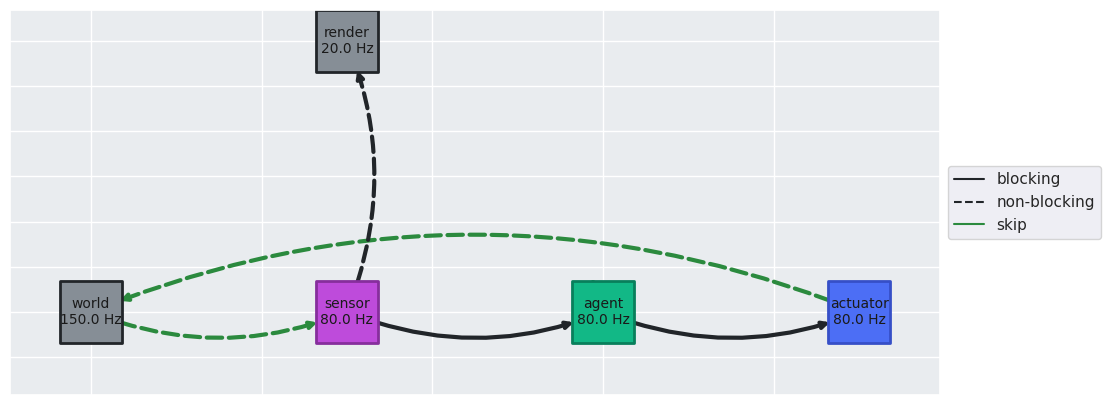

In [5]:
# Plot
fig_gr, _ = exp.show_graph(record_pre.episode[-1])

In [6]:
# Fit delays
data, info, est, dist = exp.make_delay_distributions(record_pre, num_steps=500, num_components=8, step_size=0.05, seed=0)

actuator.input(action) | Time taken: 1.15 seconds.
agent.input(last_action) | Time taken: 1.04 seconds.
agent.input(state) | Time taken: 1.04 seconds.
render.input(sensor) | Time taken: 1.02 seconds.
sensor.input(world) | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.
world.input(actuator) | Time taken: 1.12 seconds.
actuator | Time taken: 1.05 seconds.
agent | Time taken: 1.00 seconds.
render | Time taken: 1.17 seconds.
sensor | Time taken: 1.16 seconds.
world | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.


In [7]:
%matplotlib agg

# Plot gmm training
from rex.open_colors import ecolor, fcolor
est_agent = est["step"]["agent"]
fig_agent, ax_agent = plt.subplots()
ax_agent.set(title="GMM fit on computation delay (Agent)", xlabel="delay (s)", ylabel="density")
est_agent.plot_hist(ax=ax_agent, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False)

# Animate
from IPython.display import HTML
ani = est_agent.animate_training(fig=fig_agent, ax=ax_agent, num_frames=50, edgecolor=ecolor.computation, facecolor=fcolor.computation)
HTML(ani.to_html5_video())

{'actuator': {'action': None},
 'agent': {'state': None},
 'render': {'sensor': None},
 'sensor': {}}

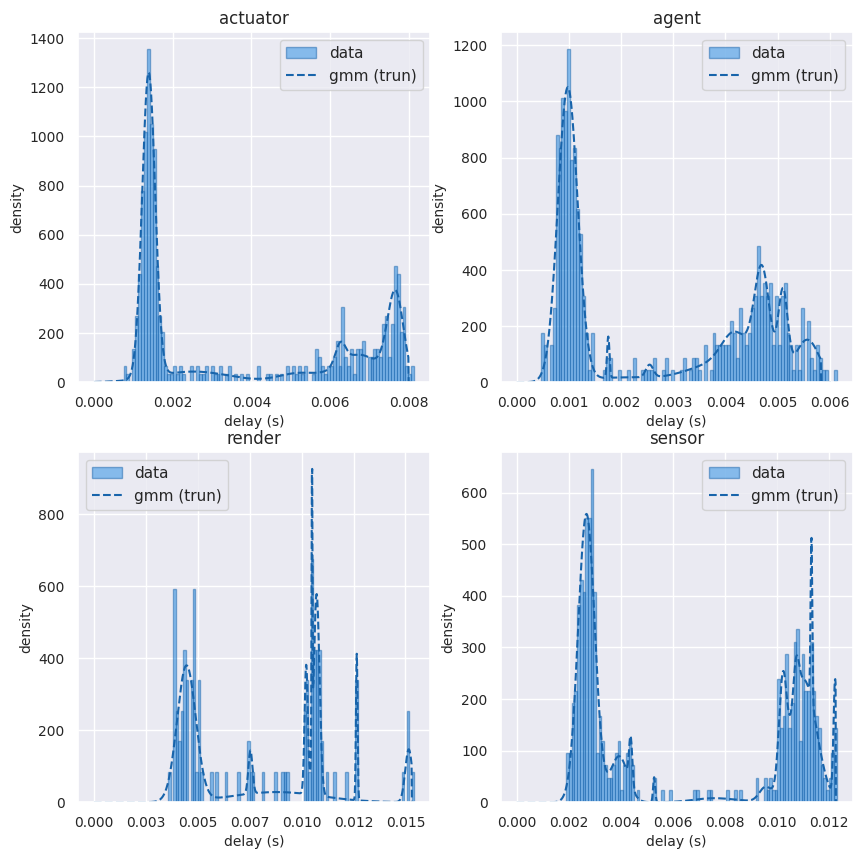

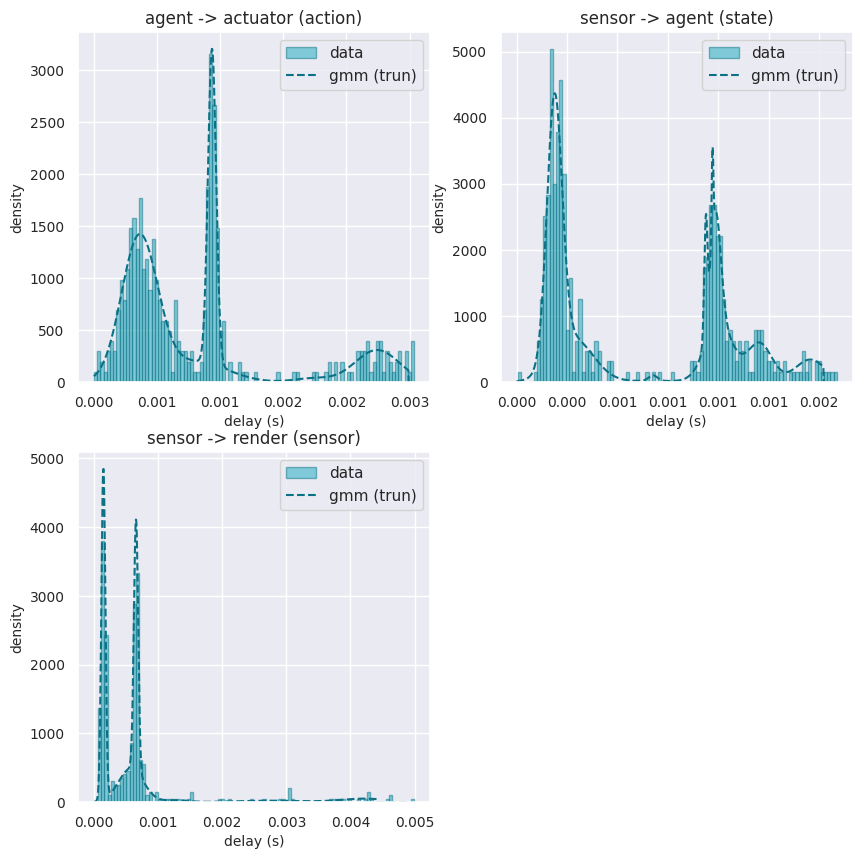

In [8]:
%matplotlib inline
# Pop world from
[_d["inputs"]["agent"].pop("last_action", None) for _d in [data, info, est, dist]]
[_d["inputs"]["sensor"].pop("world", None) for _d in [data, info, est, dist]]
[_d["inputs"].pop("world", None) for _d in [data, info, est, dist]]
[_d["step"].pop("world", None) for _d in [data, info, est, dist]]

# Split
est_inputs, est_step = est["inputs"], est["step"]
data_inputs, data_step = data["inputs"], data["step"]
info_inputs, info_step = info["inputs"], info["step"]
dist_inputs, dist_step = dist["inputs"], dist["step"]

# Plot gmm
from matplotlib.ticker import FormatStrFormatter
import numpy as onp
def plot_gmm(ax, dist, delays, i, edgecolor):
    x = onp.linspace(0, onp.max(delays), 1000)
    y = dist.pdf(x)
    if hasattr(i, "cls"):
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{i.name}")
    else:
        node_info, input_info = i
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{input_info.output} -> {node_info.name} ({input_info.name})")
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel('delay (s)', fontsize=10)
    ax.set_ylabel('density', fontsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.legend()

# Plot distributions
from rex.plot import get_subplots
fig_step, axes_step = get_subplots(est_step, figsize=(10, 10), sharex=False, sharey=False, major="row")
fig_inputs, axes_inputs = get_subplots(est_inputs, figsize=(10, 10), sharex=False, sharey=False, major="row")

# Plot measured delays
from rex.open_colors import ecolor, fcolor
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False), axes_step, est_step)
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.communication, facecolor=fcolor.communication, plot_dist=False), axes_inputs, est_inputs)

# Plot gmm
from functools import partial
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.computation), axes_step, dist_step, data_step, info_step)
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.communication), axes_inputs, dist_inputs, data_inputs, info_inputs)

In [9]:
# Trace & compile environment
cenv = exp.make_compiled_env(env, record_pre.episode[-1], max_steps=MAX_STEPS, eval_env=False, graph_type=VECTORIZED    )

Trace | name='agent' | tick=400 | deps (seq): 3942/4702 | step (seq): 1950/2056 | steps (batch): 2654/2056 | steps (vec): 2801/2056 (max_consecutive=2)


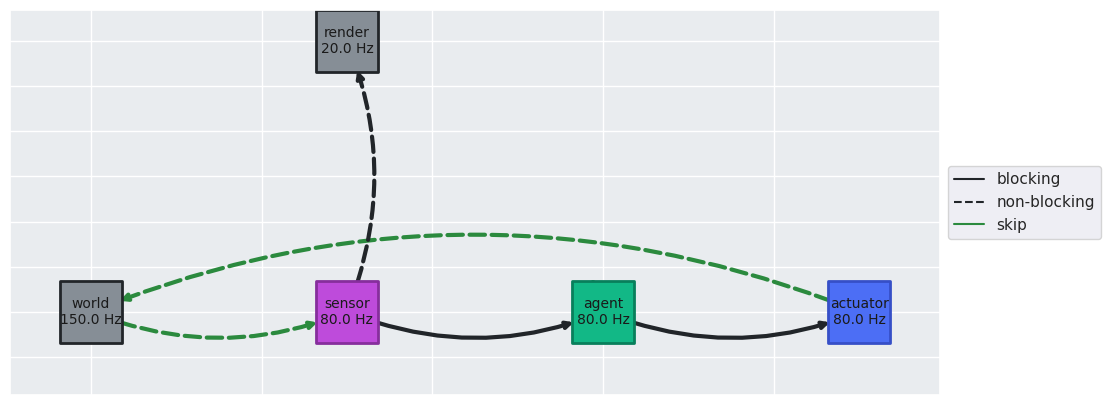

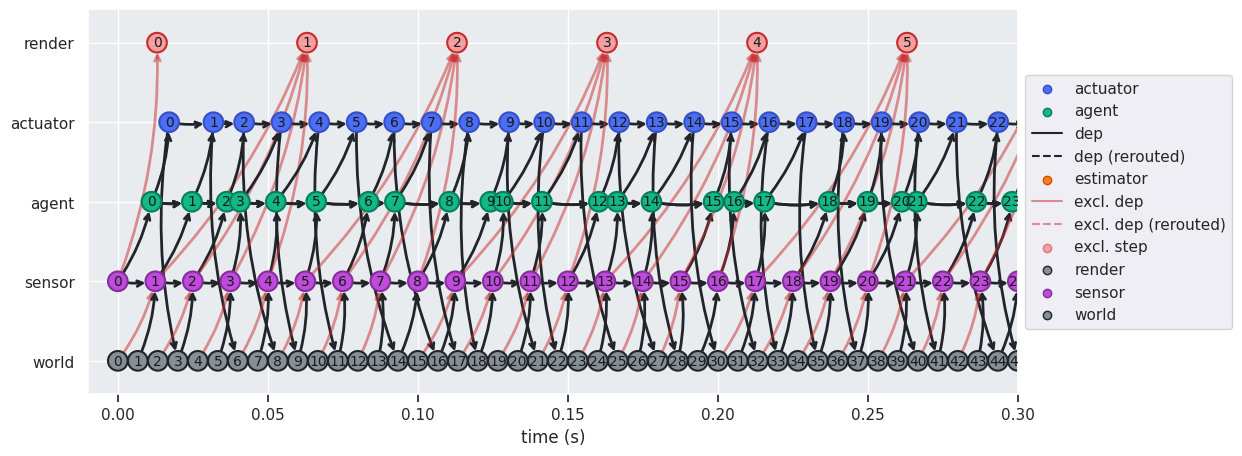

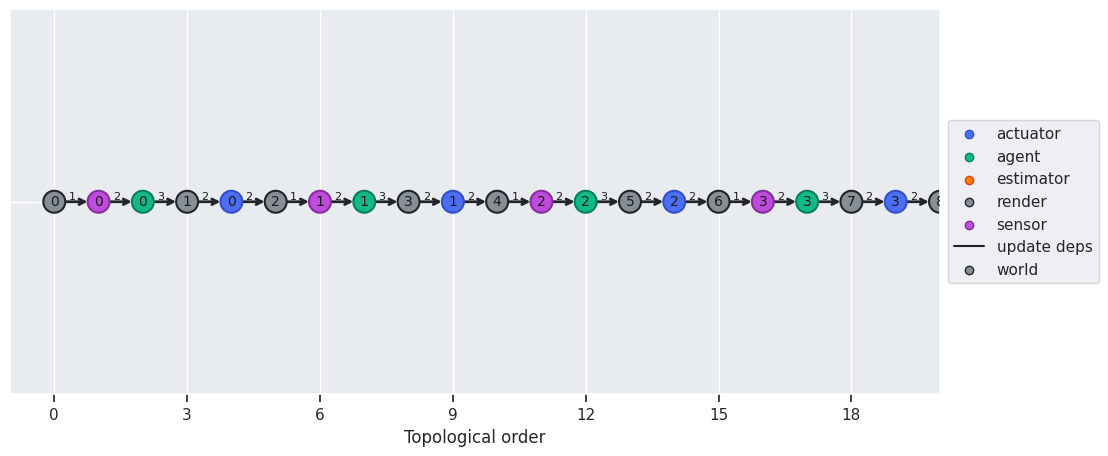

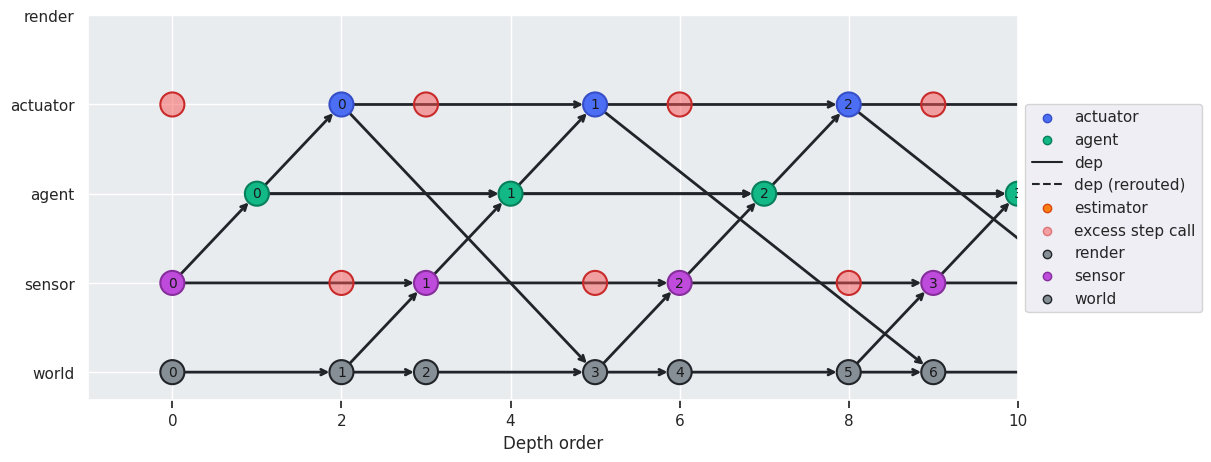

In [10]:
# Plot
fig_gr, _ = exp.show_graph(cenv.graph.trace.episode)
fig_cg, _ = exp.show_computation_graph(cenv.graph.trace,"computation", xmax=0.35)
fig_ct, _ = exp.show_computation_graph(cenv.graph.trace,"topological", xmax=0.35)
fig_cd, _ = exp.show_computation_graph(cenv.graph.trace,"depth", xmax=0.35)
# fig_com, _ = exp.show_communication(record_pre.episode[-1])
# fig_grp, _ = exp.show_grouped(record_pre.episode[-1].node[-1], "state")

In [11]:
import time
import rex.jumpy as rjp
from rex.utils import timer

rw = exp.RolloutWrapper(cenv)

nenvs = 7000
seed = jumpy.random.PRNGKey(0)
rng = jumpy.random.split(seed, num=nenvs)
for i in range(5):
    seed = jumpy.random.PRNGKey(i)
    rng = jumpy.random.split(seed, num=nenvs)
    timer = utils.timer(f"{i=}", log_level=0)
    with timer:
        res = rw.batch_rollout(rng)
    fps = env.max_steps * nenvs / timer.duration
    print(f"[{timer.name}] time={timer.duration} sec | fps={fps:.0f} steps/sec")

[i=0] time=28.7161762714386 sec | fps=97506 steps/sec
[i=1] time=19.680429458618164 sec | fps=142273 steps/sec
[i=2] time=20.05208659172058 sec | fps=139636 steps/sec
[i=3] time=18.944874048233032 sec | fps=147797 steps/sec
[i=4] time=19.068395614624023 sec | fps=146840 steps/sec


In [12]:
# Build estimator
from estimator import build_estimator
RATE_ESTIMATOR = 40
record, nodes, excludes_inputs = build_estimator(record_pre.episode[-1], rate=RATE_ESTIMATOR)
# record_est = [n for n in record.node if n.info.name == "estimator"][0]
# record_sensor = [n for n in record.node if n.info.name == "sensor"][0]
# record_actuator = [n for n in record.node if n.info.name == "actuator"][0]
# record_world = [n for n in record.node if n.info.name == "world"][0]

In [13]:
# Trace
from rex.tracer import trace
record_trace = trace(record, "estimator", tick=-1, excludes_inputs=excludes_inputs, sort="depth")

Trace | name='estimator' | tick=201 | deps (seq): 2753/5305 | step (seq): 1756/2258 | steps (batch): 2461/2258 | steps (vec): 2614/2258 (max_consecutive=4)


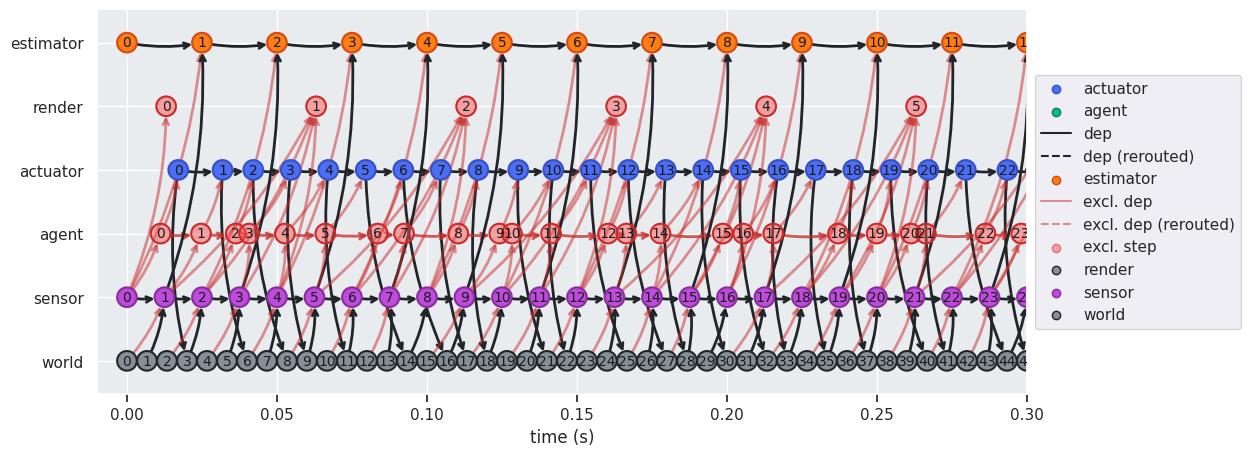

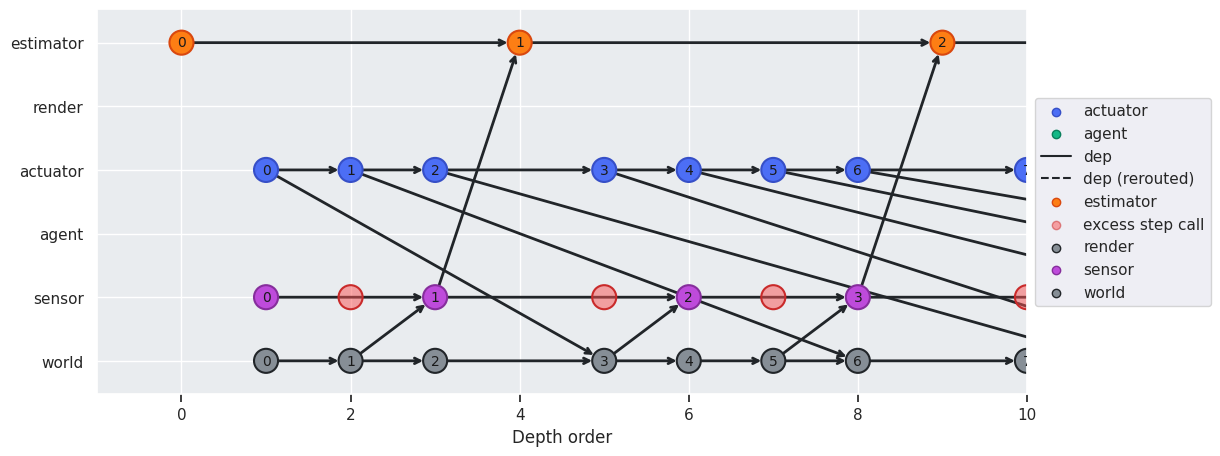

In [14]:
fig_cg, _ = exp.show_computation_graph(record_trace, plot_type="computation", xmax=0.35)
fig_dp, _ = exp.show_computation_graph(record_trace, plot_type="depth", xmax=0.35)
# fig_tp, _ = exp.show_computation_graph(record_trace, plot_type="topological", xmax=2.0)

In [15]:
# Add Estimator node to record
import flax.struct as struct

@struct.dataclass
class Loss:
    loss: jp.float32
    rloss: jp.float32
    dloss: jp.float32


alpha_dloss = nodes["world"].default_state(jumpy.random.PRNGKey(0)).replace(th=jp.float32(0.e0), th2=jp.float32(0.e0), thdot=jp.float32(0.e-2), thdot2=jp.float32(0.e-3))

def loss_fn(graph_state):
    """Get loss."""
    # Calculate reconstruction loss
    rloss_sensor = graph_state.nodes["sensor"].state.cum_loss
    rloss = rloss_sensor.cos_th + rloss_sensor.sin_th + rloss_sensor.sin_th2 + rloss_sensor.cos_th2
    # rloss += 1e-1*rloss_sensor.thdot
    rloss += 1e-3*rloss_sensor.thdot + 1e-3*rloss_sensor.thdot2

    # Calculate transition loss
    fwd_state = graph_state.nodes["world"].state
    # NOTE: mode="clip" disables negative indexing.
    est_state = rjp.tree_take(graph_state.nodes["estimator"].params.world_states, graph_state.step + 1, mode="clip")
    dloss = jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, est_state, fwd_state)
    dloss = jax.tree_util.tree_map(lambda e, a: a*e, dloss, alpha_dloss)
    dloss = jax.tree_util.tree_reduce(lambda acc, l: acc + jp.sum(l), dloss, jp.float32(0.))
    loss = rloss + dloss
    output = Loss(loss=loss, rloss=rloss, dloss=dloss)
    return output

# Compile env
from estimator import EstimatorEnv
cenv = EstimatorEnv(nodes, nodes["estimator"], record_trace, loss_fn=loss_fn, graph_type=VECTORIZED)  # todo: SEQUENTIAL --> not reverse-mode differentiable

from estimator import _init
init_gs = _init(cenv, nodes)

# Define initial params
p_tree = jax.tree_util.tree_map(lambda x: None, nodes["world"].default_params(jumpy.random.PRNGKey(0)))
# p_world = p_tree.replace(mass=jp.float32(0.3), mass2=jp.float32(0.3), K=jp.float32(1.0), J=jp.float32(0.02))
p_world = jax.tree_util.tree_map(lambda x: x * 1.2, p_tree.replace(# J=jp.float32(0.037),
                                                                   # J2=jp.float32(0.000111608131930852),
                                                                   mass=jp.float32(0.18),
                                                                   mass2=jp.float32(0.0691843934004535),
                                                                   # length=jp.float32(0.1),
                                                                   # length2=jp.float32(0.1),
                                                                   b=jp.float32(0.975872107940422),
                                                                   # b2=jp.float32(1.07098956449896e-05),
                                                                   # c=jp.float32(0.06),
                                                                   # c2=jp.float32(0.0185223578523340),
                                                                   K=jp.float32(1.09724557347983),
                                                                   ))
p_est = init_gs.nodes["estimator"].params
initial_params = {"estimator": p_est, "world": p_world}

# Define prior
def make_prior_fn(guess, multiplier):
    def prior_fn(params):
        loss = jax.tree_util.tree_map(lambda x: None, params)
        if params.get("world", None) is not None:
            wloss = jax.tree_util.tree_map(lambda x, g: 1/(multiplier*(x/g)), params["world"], guess)
            loss["world"] = wloss
        return loss
    return prior_fn

guess = nodes["world"].default_params(jumpy.random.PRNGKey(0))
prior_fn = make_prior_fn(guess, multiplier=10000)

import optax
optimizer = optax.adam(learning_rate=5e-2)

# Define callbacks
from estimator.callback import LogCallback, StateFitCallback, ParamFitCallback
targets = nodes["world"].default_params(jumpy.random.PRNGKey(0))
callbacks = {"log": LogCallback(visualize=False),
             "state_fit": StateFitCallback(visualize=False),
             "param_fit": ParamFitCallback(targets=targets, visualize=False)}

# Optimize
from estimator import fit
metrics, opt_params, opt_state, opt_gs = fit(cenv, initial_params, optimizer, init_gs,
                                             # num_steps=10, num_batches=50, lr=1e-2 works, 1e-3 thdot.
                                             prior_fn=prior_fn, num_batches=50, num_steps=5, num_training_steps=10_000,
                                             num_training_steps_per_epoch=200, callbacks=callbacks)
# Print results
print(jax.tree_util.tree_map(lambda x, y: jp.stack([x, y], axis=0), opt_params["world"], nodes["world"].default_params(jumpy.random.PRNGKey(0))))

epoch 0 | step 200 | 3.64 steps/sec | min(loss)= 2.147 | loss: 29.996 +/- 35.791 | max(loss)= 116.647
epoch 1 | step 400 | 28.62 steps/sec | min(loss)= 0.416 | loss: 1.896 +/- 0.771 | max(loss)= 3.821
epoch 2 | step 600 | 29.97 steps/sec | min(loss)= 0.183 | loss: 0.661 +/- 0.334 | max(loss)= 1.650
epoch 3 | step 800 | 27.67 steps/sec | min(loss)= 0.096 | loss: 0.374 +/- 0.254 | max(loss)= 1.382
epoch 4 | step 1000 | 31.38 steps/sec | min(loss)= 0.060 | loss: 0.220 +/- 0.172 | max(loss)= 0.643
epoch 5 | step 1200 | 32.12 steps/sec | min(loss)= 0.050 | loss: 0.220 +/- 0.180 | max(loss)= 0.660
epoch 6 | step 1400 | 31.71 steps/sec | min(loss)= 0.036 | loss: 0.188 +/- 0.168 | max(loss)= 0.797
epoch 7 | step 1600 | 29.81 steps/sec | min(loss)= 0.029 | loss: 0.129 +/- 0.142 | max(loss)= 0.665
epoch 8 | step 1800 | 31.95 steps/sec | min(loss)= 0.033 | loss: 0.089 +/- 0.056 | max(loss)= 0.360
epoch 9 | step 2000 | 33.15 steps/sec | min(loss)= 0.019 | loss: 0.085 +/- 0.079 | max(loss)= 0.457
e

In [19]:
%matplotlib agg

# Create animation
from IPython.display import HTML
ani_duration = 15.0
num_frames = len(callbacks["log"]._frames)
interval = int(1e3*ani_duration / num_frames)

# Loss animation
ani = callbacks["log"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [20]:
%matplotlib agg

# State fitting animation
ani = callbacks["state_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [21]:
%matplotlib agg
# Parameter fitting animation
ani = callbacks["param_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())